# Full first analysis of pm25 from CAMS Europe at stations data

In [6]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

from tigramite.models import LinearMediation, Prediction

import pandas as pd

/home/cide/anaconda3/envs/tigramite/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


## Load datasets

In [7]:
path = "/media/cide/datasets/CAMS/EEA_observations/pm25/"
file_pm25 = "cams-europe-pm25_nearest-pixel-observations_2020-2025.csv"
file_v10 = "cams-global-v10_nearest-pixel-observations_2020-2025.csv"
file_u10 = "cams-global-u10_nearest-pixel-observations_2020-2025.csv"
file_blh = "cams-global-blh_nearest-pixel-observations_2020-2025.csv"
file_t2m = "cams-global-t2m_nearest-pixel-observations_2020-2025.csv"
file_d2m = "cams-global-d2m_nearest-pixel-observations_2020-2025.csv"
file_pop = "cams-global-pop_nearest-pixel-observations_2020-2025.csv"
file_oro = "cams-global-elevation_nearest-pixel-observations_2020-2025.csv"

df_pm25 = pd.read_csv(path + file_pm25, index_col=0)
df_v10 = pd.read_csv(path + file_v10, index_col=0)
df_u10 = pd.read_csv(path + file_u10, index_col=0)
df_blh = pd.read_csv(path + file_blh, index_col=0)
df_t2m = pd.read_csv(path + file_t2m, index_col=0)
df_d2m = pd.read_csv(path + file_d2m, index_col=0)
df_pop = pd.read_csv(path + file_pop, index_col=0)
df_oro = pd.read_csv(path + file_oro, index_col=0)

In [8]:
stations = df_pm25.columns
station_idx = stations[100]
df_station = pd.DataFrame({"pm25":df_pm25[station_idx], "v10": df_v10[station_idx], "u10": df_u10[station_idx], "blh": df_blh[station_idx], "t2m": df_t2m[station_idx], "d2m": df_d2m[station_idx], "population": df_pop[station_idx], "oro": df_oro[station_idx]}).dropna()
df_station.index = pd.to_datetime(df_station.index)

In [4]:
import pandas as pd
path_obs_europe = "/media/cide/datasets/CAMS/EEA_observations/pm25/"
file_obs_europe_metad = "Metadata_DataExtract.csv"
df_metad = pd.read_csv(path_obs_europe + file_obs_europe_metad)
station_metad = df_metad.loc[df_metad["Sampling Point Id"]== station_idx]

/tmp/ipykernel_20913/3184401787.py:4: DtypeWarning: Columns (7,28,30,33,35,37,38,40,51,53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metad = pd.read_csv(path_obs_europe + file_obs_europe_metad)


(<Figure size 640x480 with 6 Axes>,
 array([<Axes: ylabel='pm25'>, <Axes: ylabel='v10'>, <Axes: ylabel='u10'>,
        <Axes: ylabel='blh'>, <Axes: ylabel='t2m'>, <Axes: ylabel='d2m'>],
       dtype=object))

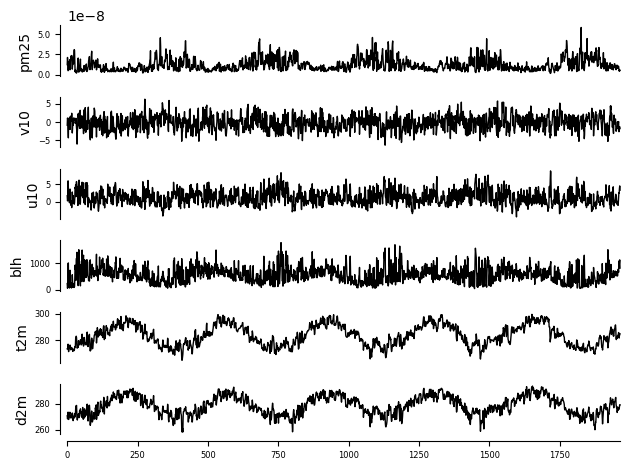

In [9]:
dataframe = pp.DataFrame(df_station.values[:,:-2], var_names=df_station.columns[:-2])
var_names = df_station.columns[:-2]
tp.plot_timeseries(dataframe)

### Investigating data dependencies and lag functions

To investigate the type of dependencies, we use the ``plot_scatterplots`` and  ``plot_densityplots`` functions to see whether the dependencies are really linear. With the argument ``matrix_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here it is left ``None`` implying lag zero.

In [10]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


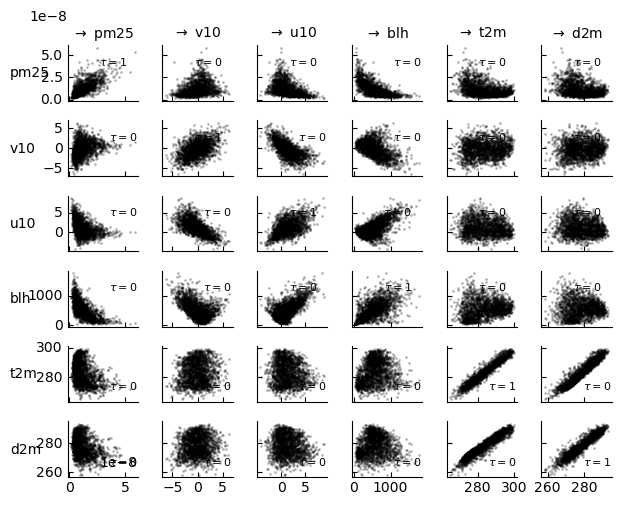

In [11]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

### Same analysis with anomalies

In [12]:
df_station_mean = df_station.groupby(df_station.index.dayofyear).mean()
df_station_std = df_station.groupby(df_station.index.dayofyear).std()

In [13]:
anom_df = None
for dd in df_station_mean.index:
    # print(dd)
    anom = (df_station.loc[df_station.index.dayofyear==dd] - df_station_mean.loc[dd])/ df_station_std.loc[dd]
    
    if anom_df is None:
        anom_df = anom
    else:
        anom_df = pd.concat([anom_df, anom])
    # print(dd, len(anom_df))
anom_df = anom_df.sort_index()

(<Figure size 640x480 with 6 Axes>,
 array([<Axes: ylabel='pm25'>, <Axes: ylabel='v10'>, <Axes: ylabel='u10'>,
        <Axes: ylabel='blh'>, <Axes: ylabel='t2m'>, <Axes: ylabel='d2m'>],
       dtype=object))

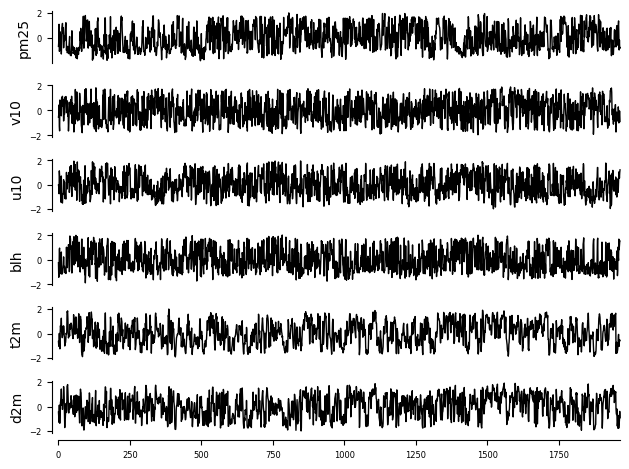

In [14]:
dataframe = pp.DataFrame(anom_df.values[:,:-2], var_names=df_station.columns[:-2])
var_names = anom_df.columns[:-2]
tp.plot_timeseries(dataframe)

In [15]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


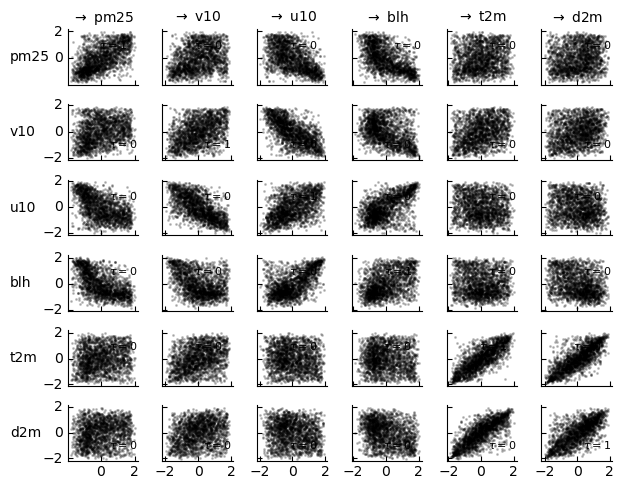

In [16]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

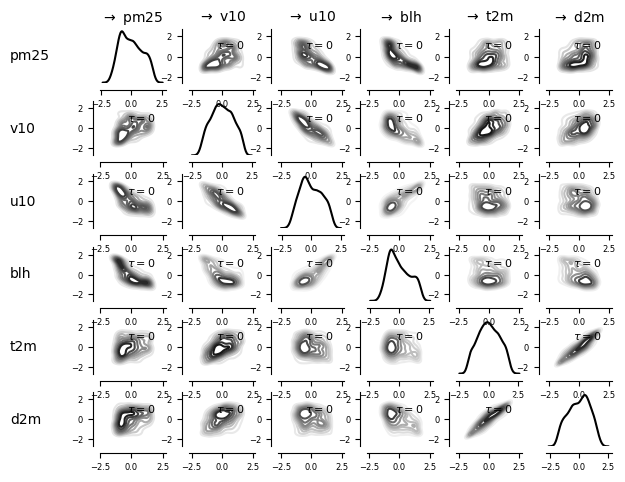

In [17]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags})
plt.show()

In [18]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


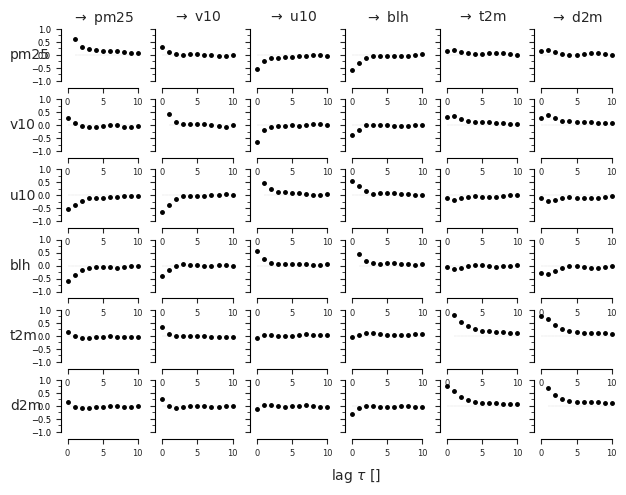

In [19]:
correlations = pcmci.get_lagged_dependencies(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## Robust ParCorr

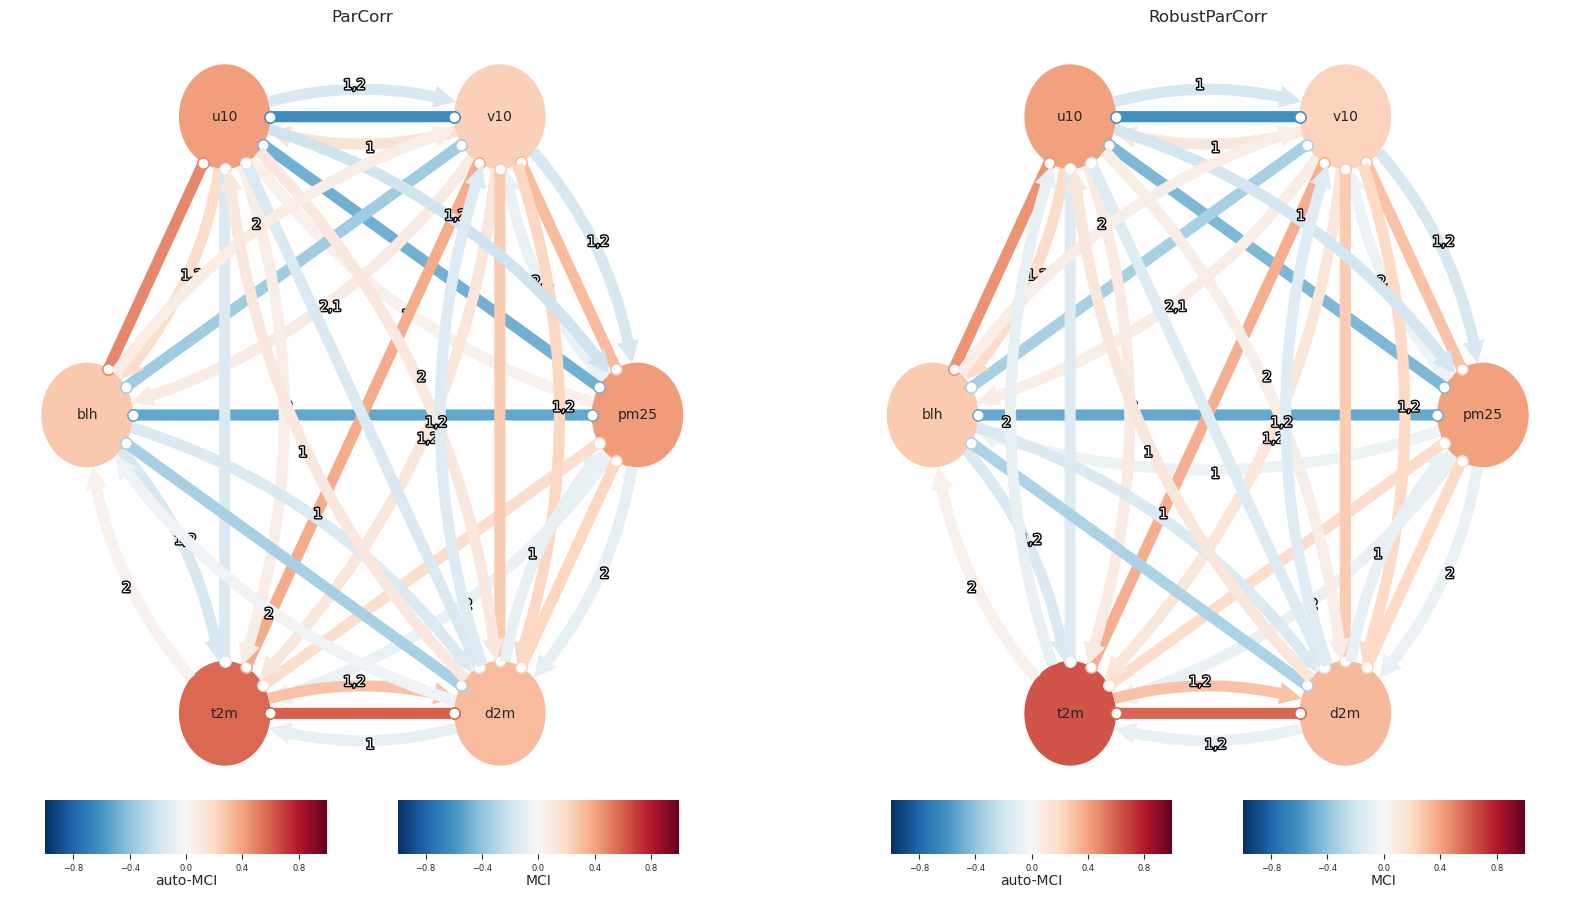

In [24]:
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr

pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr())
results = pcmci_parcorr.run_pcmci(tau_max=2)

pcmci_robust_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr())
results_robust = pcmci_robust_parcorr.run_pcmci(tau_max=2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].set_title("ParCorr")
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    # graph=results_robust,
    # var_names=var_names,
    fig_ax=(fig, axes[0]),
    # show_colorbar=False,
    )


axes[1].set_title("RobustParCorr")
tp.plot_graph(
    val_matrix=results_robust['val_matrix'],
    graph=results_robust['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    # graph=results_robust,
    # var_names=var_names,
    fig_ax=(fig, axes[1]),
    # show_colorbar=False,
    )

plt.show()

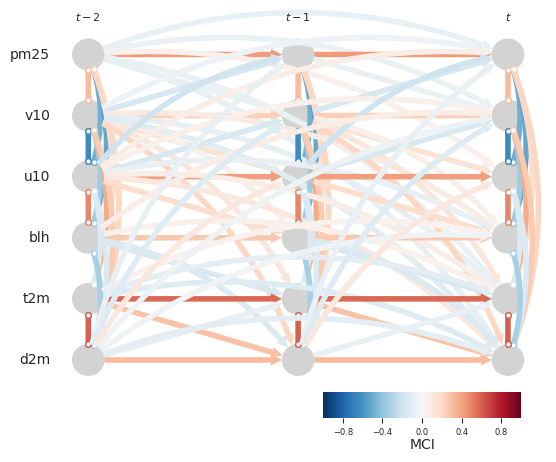

In [25]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()